In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from eisplot import plot_eis
from plotyy import plotyy, plot_parity_bin
from sklearn.metrics import mean_absolute_error, r2_score, max_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, KFold, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor

class DoubleFrequencySelector(BaseEstimator, TransformerMixin): 
    def __init__(self, freq, index_0=0, index_1=0):
        self.freq = freq
        self.index_0 = index_0
        self.index_1 = index_1
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        n = self.freq.size
        index_0 = [self.index_0, self.index_0+n]
        index_1 = [self.index_1, self.index_1+n]
        index = np.sort(np.concatenate((index_0,index_1)))
        return X_[:,index]

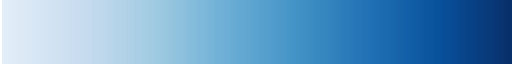

In [2]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap

blues = mpl.colormaps['Blues'].resampled(255)
newcolors = np.vstack((np.array([[1,1,1,1]]), blues(np.linspace(0.1,1,255))))

newcmp = ListedColormap(newcolors, name='Blues_white0')

mpl.colormaps.register(cmap=newcmp)

newcmp

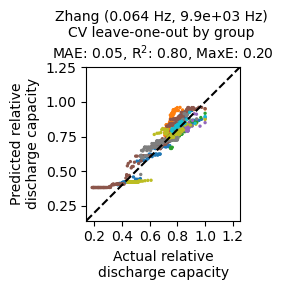

In [3]:
# Zhang data
eis_data = pd.read_csv("data/Zhang_2020/data.csv")
freq = np.loadtxt("data/Zhang_2020/freq.csv")

y = eis_data['q']
is_Z_col = eis_data.columns.str.contains('Z')
x = eis_data[eis_data.columns[is_Z_col]]

pipe_xgb_2freq = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('selector', DoubleFrequencySelector(freq=freq)),
        ('regressor', XGBRegressor())
    ]
)
param_grid = {
    # feature search
    "selector__index_0": np.arange(0, freq.size, step=6),
    "selector__index_1": np.arange(3, freq.size, step=6), # avoid redundant features
    # XGBoost hyperparameters, just to ensure we're not stuck at a bad default
    'regressor__max_depth': np.array([2, 5]),
    'regressor__min_child_weight': np.array([0.1, 0.5, 1]),
    'regressor__eta': np.array([0.05, 0.5, 1]),
}
search = GridSearchCV(pipe_xgb_2freq,
    param_grid=param_grid,
    cv=LeaveOneGroupOut(),
    scoring='neg_mean_absolute_error'
)

search.fit(x, y, groups=eis_data.seriesIdx)
y_pred_xgb_2freq = cross_val_predict(search.best_estimator_, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())

title = "Zhang (%0.2g Hz, %0.2g Hz) \n" % (freq[search.best_params_['selector__index_0']], freq[search.best_params_['selector__index_1']]) + "CV leave-one-out by group \n" + r"MAE: %0.2f, R$^2$: %0.2f, MaxE: %0.2f" % (mean_absolute_error(y, y_pred_xgb_2freq), r2_score(y, y_pred_xgb_2freq), max_error(y, y_pred_xgb_2freq))
plotyy(y, y_pred_xgb_2freq, color=eis_data.seriesIdx, title=title)

results = {
    'Zhang': (y, y_pred_xgb_2freq)
}

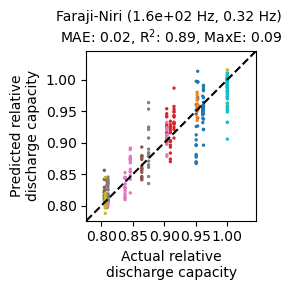

In [4]:
# Faraji-Niri data
eis_data = pd.read_csv("data/Faraji-Niri_2023/data.csv")
freq = np.loadtxt("data/Faraji-Niri_2023/freq.txt")

y = eis_data['SoH_Actual'] / 1e4
is_Z_col = eis_data.columns.str.contains('Z')
x = eis_data[eis_data.columns[is_Z_col]]

pipe_xgb_2freq = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('selector', DoubleFrequencySelector(freq=freq)),
        ('regressor', XGBRegressor())
    ]
)
param_grid = {
    # feature search
    "selector__index_0": np.arange(0, freq.size, step=6),
    "selector__index_1": np.arange(3, freq.size, step=6), # avoid redundant features
    # XGBoost hyperparameters, just to ensure we're not stuck at a bad default
    'regressor__max_depth': np.array([2, 5]),
    'regressor__min_child_weight': np.array([0.1, 0.5, 1]),
    'regressor__eta': np.array([0.05, 0.5, 1]),
}
search = GridSearchCV(pipe_xgb_2freq,
    param_grid=param_grid,
    cv=LeaveOneGroupOut(),
    scoring='neg_mean_absolute_error'
)

search.fit(x, y, groups=eis_data.Cell_Name)
y_pred_xgb_2freq = cross_val_predict(search.best_estimator_, x, y, groups=eis_data.Cell_Name, cv=LeaveOneGroupOut())

title = "Faraji-Niri (%0.2g Hz, %0.2g Hz) \n" % (freq[search.best_params_['selector__index_0']], freq[search.best_params_['selector__index_1']]) +  r"MAE: %0.2f, R$^2$: %0.2f, MaxE: %0.2f" % (mean_absolute_error(y, y_pred_xgb_2freq), r2_score(y, y_pred_xgb_2freq), max_error(y, y_pred_xgb_2freq))
plotyy(y, y_pred_xgb_2freq, color=eis_data.Cell_Name, title=title)

results['Fajiri_Niri'] = (y, y_pred_xgb_2freq)

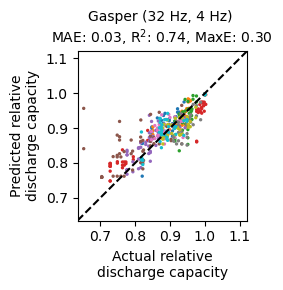

In [5]:
# Gasper data
eis_data = pd.read_csv("data/Gasper_2022/data.csv")
freq = np.loadtxt("data/Gasper_2022/freq.txt")

y = eis_data['q']
is_Z_col = eis_data.columns.str.contains('Z')
x = eis_data[eis_data.columns[is_Z_col]]

pipe_xgb_2freq = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('selector', DoubleFrequencySelector(freq=freq)),
        ('regressor', XGBRegressor())
    ]
)
param_grid = {
    # feature search
    "selector__index_0": np.arange(0, freq.size, step=6),
    "selector__index_1": np.arange(3, freq.size, step=6), # avoid redundant features
    # XGBoost hyperparameters, just to ensure we're not stuck at a bad default
    'regressor__max_depth': np.array([2, 5]),
    'regressor__min_child_weight': np.array([0.1, 0.5, 1]),
    'regressor__eta': np.array([0.05, 0.5, 1]),
}
search = GridSearchCV(pipe_xgb_2freq,
    param_grid=param_grid,
    cv=LeaveOneGroupOut(),
    scoring='neg_mean_absolute_error'
)

search.fit(x, y, groups=eis_data.seriesIdx)
y_pred_xgb_2freq = cross_val_predict(search.best_estimator_, x, y, groups=eis_data.seriesIdx, cv=LeaveOneGroupOut())

title = "Gasper (%0.2g Hz, %0.2g Hz) \n" % (freq[search.best_params_['selector__index_0']], freq[search.best_params_['selector__index_1']]) + r"MAE: %0.2f, R$^2$: %0.2f, MaxE: %0.2f" % (mean_absolute_error(y, y_pred_xgb_2freq), r2_score(y, y_pred_xgb_2freq), max_error(y, y_pred_xgb_2freq))
plotyy(y, y_pred_xgb_2freq, color=eis_data.seriesIdx, title=title)

results['Gasper'] = (y, y_pred_xgb_2freq)

In [6]:
# Ramirez-Meyers data
# cells are uniquely identifed by LocID
# grab nominal capacity from the meta data table
# grab discharge capacity from step 9 of the cycling protocol (Step.ID, Cap.mAh)
# need to reassemble EIS into [Z_real, Z_imag] data format

meta_data = pd.read_excel('data/RamirezMeyers_2023/data.xlsx', sheet_name='MetaData')
capacity_checks = pd.read_excel('data/RamirezMeyers_2023/data.xlsx', sheet_name='Cycling Data')
eis_data = pd.read_excel('data/RamirezMeyers_2023/data.xlsx', sheet_name='EIS Data')
freq = np.loadtxt('data/RamirezMeyers_2023/freq.txt')

meta_data = meta_data[['LocID','InitialCap.mAh']]
meta_data = meta_data.rename(columns={'LocID': 'Cell ID'})

In [7]:
cell_ids_capacity = capacity_checks['LocID'].unique()
capacities = []
eis = []
for cell in cell_ids_capacity:
    cc_check = capacity_checks.loc[capacity_checks['LocID'] == cell]
    capacity = np.max(cc_check.loc[cc_check['Step.ID'] == 9, 'Cap.mAh'])
    capacities.append(capacity)

cell_ids_eis = eis_data['LocID'].unique()
eis = []
for cell in cell_ids_eis:
    this_eis = eis_data.loc[eis_data['LocID'] == cell]
    z_real = this_eis['Re(Z)/Ohm'].to_list()
    z_imag = this_eis['-Im(Z)/Ohm'].to_list()
    z = np.array(z_real + z_imag)
    eis.append(z)

capacity_data = pd.DataFrame.from_dict({'Cell ID': cell_ids_capacity, 'capacity (mAh)': capacities})
eis_scraped = pd.DataFrame.from_dict({'Cell ID': cell_ids_eis, 'eis data': eis})
ramirez_data = eis_scraped.merge(capacity_data, on='Cell ID')
ramirez_data = ramirez_data.merge(meta_data, on='Cell ID')

y = ramirez_data['capacity (mAh)'] / ramirez_data['InitialCap.mAh']
x = ramirez_data['eis data'].to_numpy()
x = np.stack(x, axis=0)

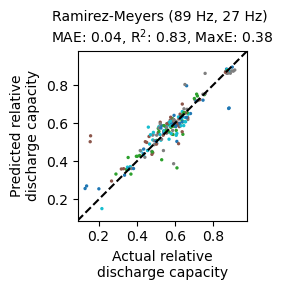

In [8]:
pipe_xgb_2freq = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('selector', DoubleFrequencySelector(freq=freq)),
        ('regressor', XGBRegressor())
    ]
)
param_grid = {
    # feature search
    "selector__index_0": np.arange(0, freq.size, step=6),
    "selector__index_1": np.arange(3, freq.size, step=6), # avoid redundant features
    # XGBoost hyperparameters, just to ensure we're not stuck at a bad default
    'regressor__max_depth': np.array([2, 5]),
    'regressor__min_child_weight': np.array([0.1, 0.5, 1]),
    'regressor__eta': np.array([0.05, 0.5, 1]),
}

# there's only one data row per cell (all measurements are independent) so we just have to do random splits, unlike the other data sets
n_splits = 5
rng = 1234
splitter = KFold(n_splits=n_splits, shuffle=True, random_state=rng)
search = GridSearchCV(pipe_xgb_2freq,
    param_grid=param_grid,
    cv=splitter,
    scoring='neg_mean_absolute_error'
)

search.fit(x, y, groups=ramirez_data['Cell ID'])
y_pred_xgb_2freq = cross_val_predict(search.best_estimator_, x, y, groups=ramirez_data['Cell ID'], cv=splitter)

title = "Ramirez-Meyers (%0.2g Hz, %0.2g Hz) \n" % (freq[search.best_params_['selector__index_0']], freq[search.best_params_['selector__index_1']]) + r"MAE: %0.2f, R$^2$: %0.2f, MaxE: %0.2f" % (mean_absolute_error(y, y_pred_xgb_2freq), r2_score(y, y_pred_xgb_2freq), max_error(y, y_pred_xgb_2freq))
for i, (train_index, test_index) in enumerate(splitter.split(x)):
    ramirez_data.loc[test_index, 'kfold split'] = i
plotyy(y, y_pred_xgb_2freq, color=ramirez_data['kfold split'], title=title)

results['Ramirez_Meyers'] = (y, y_pred_xgb_2freq)

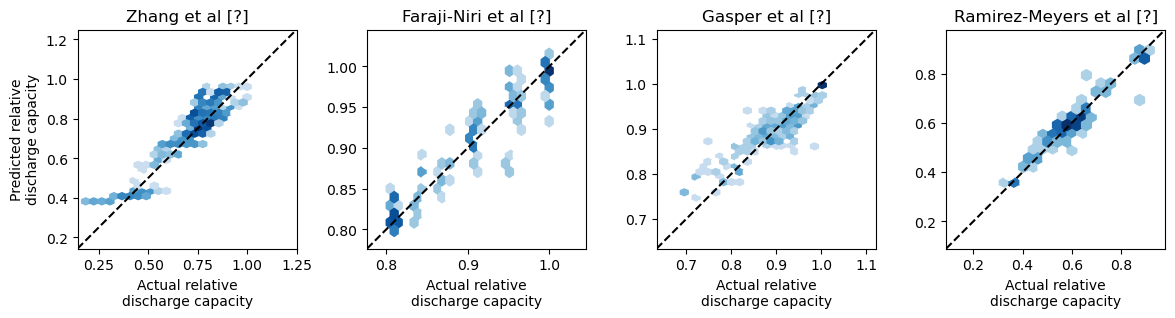

In [16]:
# titles = [
#     "Zhang et al, Nature\nComms., 11 (2020) 1706",
#     "Faraji-Niri et al, J. Energy\nStor., 58 (2023) 106295",
#     "Gasper et al, Cell Reports\nPhys. Sci., 3 (2022) 101184",
#     "Ramirez-Meyers et al, J. Energy\nStor., 59 (2023) 106472"
# ]
titles = [
    "Zhang et al [10]",
    "Faraji-Niri et al [11]",
    "Gasper et al [9]",
    "Ramirez-Meyers et al [12]"
]

fig, axes = plt.subplots(1,4, figsize=(12,3))
for i, dset in enumerate(results):
    ax = axes[i]
    y_y = results[dset]
    y = y_y[0]
    y_pred_xgb_2freq = y_y[1]
    # h = ax.hist2d(y, y_pred_xgb_2freq, bins=25, cmap='Blues_white0')
    h = ax.hexbin(y, y_pred_xgb_2freq, gridsize=20, cmap='Blues_white0', bins='log')
    ax.set_aspect('equal')
    ax.set_xlabel('Actual relative\ndischarge capacity')
    if i == 0:
        ax.set_ylabel('Predicted relative\ndischarge capacity')
    ax.axis('square')
    ax.set_title(titles[i])
    # plt.colorbar(label='Counts')
    # Diagonal line for guiding the eye
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lims = np.concatenate((xlim, ylim))
    lims = np.array([min(lims), max(lims)])
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_autoscale_on(False)
    ax.plot(lims, lims, '--k')

plt.tight_layout()
plt.savefig('eis_models.pdf', dpi=600)
plt.savefig('eis_models.png', dpi=600)

In [18]:
for dset in results:
    y_y = results[dset]
    y = y_y[0]
    y_pred_xgb_2freq = y_y[1]
    print(mean_absolute_percentage_error(y, y_pred_xgb_2freq), r2_score(y, y_pred_xgb_2freq))

0.08170760181151568 0.7968202126236855
0.01867812877722653 0.8860270444485471
0.03171626362920235 0.7431983380217614
0.09212562921809933 0.832484911463611
